In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
# Path to your shapefile
path = "../trimmed_manhattan_shape/trimmed_manhattan.shp"

gdf = gpd.read_file(path)

In [13]:
print("CRS:", gdf.crs)
print("Geometry types:", gdf.geom_type.unique())
print("Columns:", gdf.columns.tolist())

CRS: EPSG:4326
Geometry types: ['LineString']
Columns: ['osm_id', 'name', 'highway', 'oneway', 'geometry']


In [9]:
gdf.head(10)

,osm_id,name,highway,oneway,geometry
0,132500852,Dyckman Street,secondary,None,"LINESTRING (-73.93117 40.86876, -73.93035 40.8..."
1,1098148716,Riverside Drive,secondary,yes,"LINESTRING (-73.95539 40.82344, -73.95537 40.8..."
2,422298615,5th Avenue,secondary,yes,"LINESTRING (-73.97348 40.76365, -73.97353 40.7..."
3,295999078,West 100th Street,residential,yes,"LINESTRING (-73.97314 40.79858, -73.9731 40.79..."
4,275298540,West 112th Street,residential,yes,"LINESTRING (-73.95448 40.8007, -73.95431 40.80..."
5,46481740,West 38th Street,residential,yes,"LINESTRING (-73.9989 40.75776, -73.99855 40.75..."
6,420904618,West 42nd Street,primary,None,"LINESTRING (-73.99547 40.75963, -73.99534 40.7..."
7,544549058,East 56th Street,residential,yes,"LINESTRING (-73.96806 40.7596, -73.96795 40.75..."
8,1123883122,West 79th Street,secondary,None,"LINESTRING (-73.97988 40.78381, -73.98008 40.7..."
9,5670859,Morningside Avenue,residential,no,"LINESTRING (-73.95819 40.80561, -73.95813 40.8..."


In [16]:
# If CRS is geographic (lat/lon), reproject to EPSG: 2263 (NY State Plane)
if gdf.crs is not None and gdf.crs.is_geographic:
    gdf = gdf.to_crs(epsg=2263)
    print("Reprojected CRS: ", gdf.crs)

Reprojected CRS:  EPSG:2263


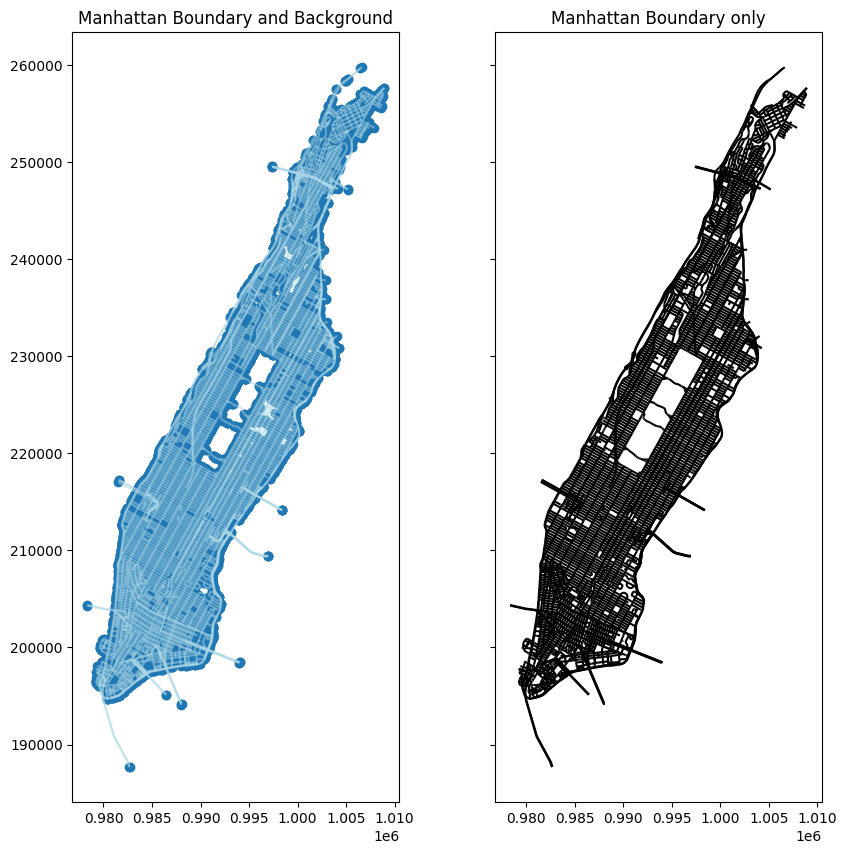

In [21]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10, 10), sharey=True)
gdf.boundary.plot(ax=ax1, linewidth=1)
gdf.plot(ax=ax1, alpha=0.5, color="lightblue", edgecolor="black")
ax1.set_title("Manhattan Boundary and Background")

gdf.plot(ax = ax2,figsize=(8, 8), edgecolor="black", facecolor="none")
ax2.set_title("Manhattan Boundary only")

plt.show()

In [22]:
from dataclasses import dataclass
from typing import Dict, List, Tuple
from collections import defaultdict
from shapely.geometry import LineString, MultiLineString

Node = Tuple[float, float]     # (x, y)
EdgeId = Tuple[Node, Node]     # directed edge


@dataclass
class Edge:
    start: Node
    end: Node
    free_time: float      # e.g. seconds
    capacity: float       # vehicles per time unit
    alpha: float = 0.15   # BPR parameters
    beta: float = 4.0

    def travel_time(self, flow: float) -> float:
        x = flow / self.capacity if self.capacity > 0 else 0.0
        return self.free_time * (1.0 + self.alpha * (x ** self.beta))


Graph = Dict[Node, List[EdgeId]]


@dataclass
class TrafficNetwork:
    graph: Graph
    edges: Dict[EdgeId, Edge]


In [24]:
def make_node(x: float, y: float, ndigits: int = 3) -> Node:
    # rounding keeps nodes consistent instead of having tiny float differences
    return round(x, ndigits), round(y, ndigits)

In [25]:
def network_from_streets_gdf(
    streets_gdf: gpd.GeoDataFrame,
    default_speed_m_s: float = 8.33,   # ~30 km/h
    default_capacity: float = 500.0    # arbitrary, you can tune
) -> TrafficNetwork:

    graph: Dict[Node, List[EdgeId]] = defaultdict(list)
    edges: Dict[EdgeId, Edge] = {}

    for idx, row in streets_gdf.iterrows():
        geom = row.geometry
        if geom is None:
            continue

        # Handle MultiLineString and LineString
        if isinstance(geom, MultiLineString):
            line_geoms = list(geom.geoms)
        elif isinstance(geom, LineString):
            line_geoms = [geom]
        else:
            continue  # ignore other types

        for line in line_geoms:
            coords = list(line.coords)
            if len(coords) < 2:
                continue

            # edges between consecutive points
            for (x1, y1), (x2, y2) in zip(coords[:-1], coords[1:]):
                u = make_node(x1, y1)
                v = make_node(x2, y2)

                seg = LineString([(x1, y1), (x2, y2)])
                length_m = seg.length

                free_time = length_m / default_speed_m_s if default_speed_m_s > 0 else 1.0

                # directed edge u -> v
                e1 = (u, v)
                if e1 not in edges:
                    edges[e1] = Edge(start=u, end=v,
                                     free_time=free_time,
                                     capacity=default_capacity)
                    graph[u].append(e1)

                # if you want bidirectional by default
                e2 = (v, u)
                if e2 not in edges:
                    edges[e2] = Edge(start=v, end=u,
                                     free_time=free_time,
                                     capacity=default_capacity)
                    graph[v].append(e2)

    return TrafficNetwork(graph=dict(graph), edges=edges)

### Build the graph

In [27]:
manhattan_network = network_from_streets_gdf(gdf)
print(f"# nodes: {len(manhattan_network.graph)}")
print(f"# edges: {len(manhattan_network.edges)}")

# nodes: 37086
# edges: 81228


### Convert to NetworkX

# NX nodes: 37086 # NX edges: 81228


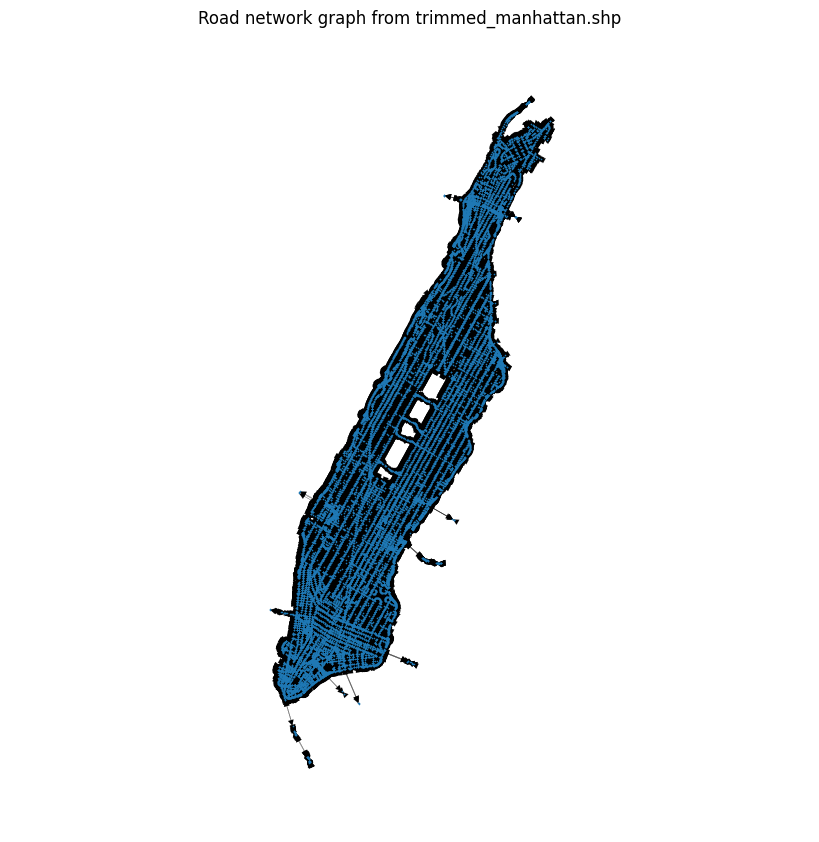

In [30]:
import networkx as nx
import matplotlib.pyplot as plt

def to_networkx(network: TrafficNetwork) -> nx.DiGraph:
    G = nx.DiGraph()
    for node in network.graph.keys():
        G.add_node(node, x=node[0], y=node[1])
    for e_id, edge in network.edges.items():
        G.add_edge(edge.start, edge.end,
                   free_time=edge.free_time,
                   capacity=edge.capacity)
    return G

G_nx = to_networkx(manhattan_network)
print("# NX nodes:", G_nx.number_of_nodes(), "# NX edges:", G_nx.number_of_edges())

pos = {n: (n[0], n[1]) for n in G_nx.nodes()}
plt.figure(figsize=(8, 8))
nx.draw(G_nx, pos=pos, node_size=1, linewidths=0.1, width=0.1)
plt.axis("equal")
plt.title("Road network graph from trimmed_manhattan.shp")
plt.show()

### Agents + OD selection

In [31]:
Node = Tuple[float, float]       # already used in your network
EdgeId = Tuple[Node, Node]       # directed edge
EdgeFlows = Dict[EdgeId, float]  # flow per edge


@dataclass
class Agent:
    origin: Node
    destination: Node
    path: List[Node] = None

### Random selection

In [32]:
import random

def sample_agents_random(network, num_agents: int) -> List[Agent]:
    nodes = list(network.graph.keys())
    agents: List[Agent] = []
    for _ in range(num_agents):
        o = random.choice(nodes)
        d = random.choice(nodes)
        while d == o:
            d = random.choice(nodes)
        agents.append(Agent(origin=o, destination=d))
    return agents

### North to Sout Commute

In [33]:
def sample_agents_north_south(network, num_agents: int, band_split: float = 0.5) -> List[Agent]:
    nodes = list(network.graph.keys())
    ys = [y for (_, y) in nodes]
    y_min, y_max = min(ys), max(ys)
    y_mid = y_min + band_split * (y_max - y_min)

    north_nodes = [n for n in nodes if n[1] >= y_mid]
    south_nodes = [n for n in nodes if n[1] <= y_mid]

    assert north_nodes and south_nodes, "North/south bands are empty – check CRS or band_split."

    agents: List[Agent] = []
    for _ in range(num_agents):
        o = random.choice(north_nodes)
        d = random.choice(south_nodes)
        agents.append(Agent(origin=o, destination=d))
    return agents

### Dijkstra on TrafficNetwork

In [34]:
import heapq
from typing import Optional

def dijkstra(network,
             source: Node,
             target: Node,
             edge_flows: EdgeFlows) -> List[Node]:
    graph, edges = network.graph, network.edges

    dist: Dict[Node, float] = {source: 0.0}
    prev: Dict[Node, Node] = {}
    pq = [(0.0, source)]
    visited = set()

    while pq:
        d, u = heapq.heappop(pq)
        if u in visited:
            continue
        visited.add(u)

        if u == target:
            break

        for edge_id in graph.get(u, []):
            edge = edges[edge_id]
            v = edge.end
            w = edge.travel_time(edge_flows[edge_id])  # cost depends on current flow
            nd = d + w

            if v not in dist or nd < dist[v]:
                dist[v] = nd
                prev[v] = u
                heapq.heappush(pq, (nd, v))

    if target not in dist:
        return []  # no path found

    # Reconstruct path
    path: List[Node] = []
    cur = target
    while cur != source:
        path.append(cur)
        cur = prev[cur]
    path.append(source)
    path.reverse()
    return path

### Utility function: get edges from a path

In [35]:
def edges_from_path(path: List[Node]) -> List[EdgeId]:
    return list(zip(path[:-1], path[1:]))

### SPA routing: selfish, sequential assignment

In [36]:
def spa_route_all(network, agents: List[Agent]) -> Tuple[List[Agent], EdgeFlows]:
    edge_flows: EdgeFlows = defaultdict(float)
    edges = network.edges

    for agent in agents:
        path = dijkstra(network, agent.origin, agent.destination, edge_flows)
        agent.path = path

        for e in edges_from_path(path):
            edge_flows[e] += 1.0  # 1 vehicle per agent

    return agents, edge_flows

### World Utility

In [37]:
def total_system_travel_time(network, edge_flows: EdgeFlows) -> float:
    total = 0.0
    for e_id, flow in edge_flows.items():
        edge = network.edges[e_id]
        total += flow * edge.travel_time(flow)
    return total

### Experiment (function definition)

In [38]:
def run_spa_experiment(network,
                       num_agents: int = 500,
                       od_mode: str = "north_south"):
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    elif od_mode in ("north_south", "north-south"):
        agents = sample_agents_north_south(network, num_agents)
    else:
        raise ValueError(f"Unknown od_mode: {od_mode}")

    agents, edge_flows = spa_route_all(network, agents)
    G = total_system_travel_time(network, edge_flows)

    print(f"SPA experiment with {num_agents} agents ({od_mode} O/D)")
    print(f"Total system travel time G: {G:.2f}")
    print(f"Used edges: {len([e for e,f in edge_flows.items() if f > 0])} / {len(network.edges)}")

    return agents, edge_flows, G

In [54]:
agents, edge_flows, G_spa = run_spa_experiment(manhattan_network,
                                               num_agents=500,
                                               od_mode="north_south")

SPA experiment with 500 agents (north_south O/D)
Total system travel time G: 2144551.87
Used edges: 23344 / 81228


### Visualize routes

In [48]:
def routes_to_gdf(agents, crs):
    geoms = []
    for agent in agents:
        # agent.path is a list of (x, y) nodes
        if agent.path is not None and len(agent.path) > 1:
            geoms.append(LineString(agent.path))
    routes_gdf = gpd.GeoDataFrame(geometry=geoms, crs=crs)
    return routes_gdf

In [49]:
routes_gdf = routes_to_gdf(agents, crs=gdf.crs)
print(routes_gdf.head())

                                            geometry
0  LINESTRING (1003282.254 232075.565, 1003282.40...
1  LINESTRING (1001947.021 227466.373, 1001926.22...
2  LINESTRING (1002719.782 231634.466, 1002716.70...
3  LINESTRING (998742.359 239026.541, 998731.991 ...
4  LINESTRING (1000506.976 248621.642, 1000496.26...


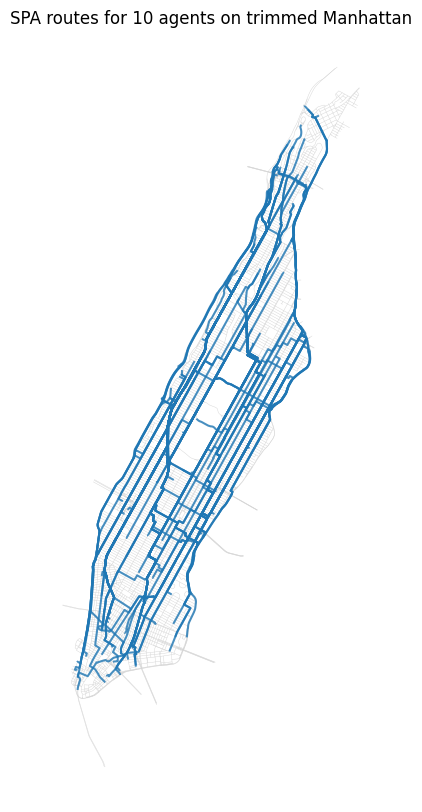

In [58]:
fig, ax = plt.subplots(figsize=(8, 10))

# base map: all streets
gdf.plot(ax=ax, linewidth=0.3, color="lightgray")

# overlay: SPA routes
routes_gdf.plot(ax=ax, linewidth=1.5, alpha=0.8)

ax.set_title("SPA routes for 10 agents on trimmed Manhattan")
ax.set_axis_off()
plt.show()

### Edges flow as heatmap

In [55]:
def edge_flows_to_gdf(edge_flows, network, crs):
    geoms = []
    flows = []
    for (u, v), flow in edge_flows.items():
        if flow <= 0:
            continue
        geoms.append(LineString([u, v]))
        flows.append(flow)
    gdf = gpd.GeoDataFrame({"flow": flows}, geometry=geoms, crs=crs)
    return gdf

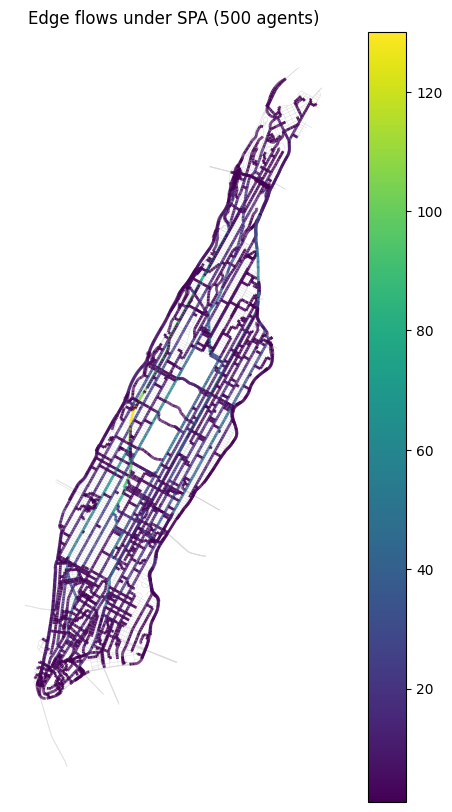

In [57]:
flows_gdf = edge_flows_to_gdf(edge_flows, manhattan_network, crs=gdf.crs)

fig, ax = plt.subplots(figsize=(8, 10))
gdf.plot(ax=ax, linewidth=0.3, color="lightgray")

flows_gdf.plot(
    ax=ax,
    column="flow",
    linewidth=2,
    alpha=0.9,
    legend=True,
    cmap="viridis"   # or any other colormap you like
)

ax.set_title("Edge flows under SPA (500 agents)")
ax.set_axis_off()
plt.show()